# 고객이탈 예측
    - 팀명 : 오지는 오지은

In [1]:
# 명확한 목표와 분석 결과물로 결론이 있어야 함
# 분석방향의 독창성(30점) - 새롭고 가시적인 차별성 보유 여부, 분석 논리 구조의 명확성
# 데이터 활용성(50점) - 데이터 전처리의 완성도/체계성, 적절한 데이터 분석 기법의 적용, 분석 방향의 명확한 설계 및 결과 도출
# 분석 완성도(20점) - 데이터 분석 결과의 효과적인 시각화, 코드 및 구조화 완성도

# 0. Contents

0. Introduction
1. Setup
2. Preparation<br>
       2.1 package<br>
       2.2 Data<br>
       2.3 Data dictionary 
3. EDA
       3.1 Dealing with the null<br>
       3.2 Categorical Encoding<br>
       3.3 Dealing with the outliers<br>
       3.4 Feature Scaling<br>
       3.5 Check Target Distribution 
4. Model<br>
       4.1 Model Selection & Hyper Parameter Tuning<br>
5. Prediction of TEST Data & Result

# 1. Introduction - 주제소개

 명확한 목표와 분석 결과물로 결론이 있어야 함

# 2. Setup

## 2-1. package install

In [2]:
'''
!pip install plotly jupyterlab --quiet
!pip install cufflinks --quiet
'''

'\n!pip install plotly jupyterlab --quiet\n!pip install cufflinks --quiet\n'

In [1]:
# 파이썬 버전 확인
import sys
print(sys.version)

3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]


In [1]:
# pandas, numpy 패키지 임포트
import pandas as pd
import numpy as np

# 시각화 패키지 임포트
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# 라벨 인코딩 패키지 임포트 - 범주형데이터 변환
from sklearn.preprocessing import LabelEncoder

# 데이터 전처리 패키지 임포트 - 결측치
from sklearn.impute import KNNImputer

# 데이터 전처리 패키지 임포트 - 피처 선택
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# 데이터 모델링 패키지 임포트
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score  # train, test 데이터 분리 , cv
from imblearn.over_sampling import ADASYN, SMOTE

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

## 2-2. Dataset Load
   - 데이터 읽기
   - 데이터 구체화


In [2]:
df = pd.read_csv(f'../0.data/bank_churner.csv', encoding ='utf-8') # 경진대회data

# 이탈여부 --> target칼럼으로 변경
df.loc[:, 'target'] = df.loc[:,'is_churned']
df = df.drop(columns = ['cstno','is_churned']) 

# 원데이터 보존
df_original = df.copy() 

print(df.shape)

(8101, 21)


In [3]:
# df_train, df_test 데이터 분리
df_train, df_test = train_test_split(df, test_size=0.3, random_state = 100)

# trian, test 데이터 분리
X = df.drop(columns = ['target'])
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

print(f'Train Data : {x_train.shape}')
print(f'Test Data : {x_test.shape}')

Train Data : (5670, 20)
Test Data : (2431, 20)


In [4]:
df.info() # 칼럼21 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             8101 non-null   int64  
 1   age                    8101 non-null   int64  
 2   sex                    7293 non-null   object 
 3   dependent_num          8101 non-null   int64  
 4   education              8101 non-null   object 
 5   marital_stat           8101 non-null   object 
 6   imcome_cat             6482 non-null   object 
 7   card_type              8101 non-null   object 
 8   mon_on_book            8101 non-null   int64  
 9   tot_product_count      8101 non-null   int64  
 10  months_inact_for_12m   8101 non-null   int64  
 11  contact_cnt_for_12m    8101 non-null   int64  
 12  credit_line            8101 non-null   float64
 13  tot_revol_balance      6580 non-null   float64
 14  mean_open_to_buy       8101 non-null   float64
 15  tot_

## 2-3. Data Dictionary

### 2-3-1. 데이터 타입별 칼럼보기

<font color=green> 변수분류 </font>

In [5]:
df = df.drop(columns = ['target']) # target 칼럼 제거

In [6]:
# 데이터 타입별 칼럼구분
col_numeric = df.select_dtypes(include=["int64","float64"]).columns.tolist() # 수치형 + 연속형 변수
col_num = df.select_dtypes(include=["int64"]).columns.tolist()               # 수치형 변수
col_con = df.select_dtypes(include=["float64"]).columns.tolist()             # 연속형 변수
col_cat = df.select_dtypes(include=["object"]).columns.tolist()              # 범주형 변수

* 수치형 변수

In [7]:
col_num

# age                  : 고객 나이
# dependent_num        : 부양가족 수
# mon_on_book          : 고객이 은행과 거래한 개월 수
# tot_product_count    : 고객이 가지고 있는 은행 상품 수
# months_inact_for_12m : 고객이 12개월 동안 은행과 거래하지 않은 개월 수
# contact_cnt_for_12m  : 고객이 12개월 동안 은행에 연락한 횟수


['Unnamed: 0',
 'age',
 'dependent_num',
 'mon_on_book',
 'tot_product_count',
 'months_inact_for_12m',
 'contact_cnt_for_12m']

* 연속형 변수

In [8]:
col_con

# credit_line           : 신용 한도
# tot_revol_balance     : 리볼빙 잔액
# mean_open_to_buy      : 평균 사용가능 신용 한도
# tot_amt_ratio_q4_q1   : 1분기 대비 4분기 거래 금액 비율
# tot_trans_amt_for_12m : 고객이 12개월 동안 거래한 총 금액
# tot_trans_cnt_for_12m : 고객이 12개월 동안 거래한 총 횟수
# tot_cnt_ratio_q4_q1   : 1분기 대비 4분기 거래 횟수 비율
# mean_util_pct         : 평균 신용카드 사용률(한도소진율)


['credit_line',
 'tot_revol_balance',
 'mean_open_to_buy',
 'tot_amt_ratio_q4_q1',
 'tot_trans_amt_for_12m',
 'tot_trans_cnt_for_12m',
 'tot_cnt_ratio_q4_q1',
 'mean_util_pct']

* 범주형변수

In [9]:
col_cat

# sex             성별
# education       교육수준
# marital_stat    결혼상태
# income_cat      수입규모
# card_type       카드종류


['sex', 'education', 'marital_stat', 'imcome_cat', 'card_type']

----

#### 2) 칼럼 타입별 특징파악
    - basic statistics
    - 분포
    - null값 확인
    - outlier 확인


##### (1) target변수

<font color=green> * basic statistics</font>

유지 : 6801건, 83.95%
이탈 : 1300건, 16.05%


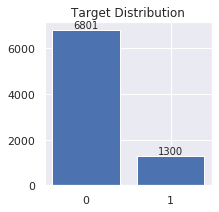

In [10]:
# taregt변수 확인
for dvcd, val, val_norm in zip(y, y.value_counts(), y.value_counts(normalize=True)):
    flag = '이탈' if dvcd == 1 else '유지'
    
    print(f'{flag} : {val}건, {val_norm*100:.2f}%')

# target변수 시각화                                               
plt.figure(figsize=(3,3))                                                   # 그래프 크기 조정            
for i, v in enumerate(y.value_counts()):                                    # 막대그래프 위에 숫자 표시
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=10)
plt.bar(y.value_counts().index, y.value_counts(), color="b", width=0.8)     # 막대 굵기 조정
plt.xticks([0,1])                                                           # 그래프x축 간격 조정
plt.title('Target Distribution')
plt.show()

> <br> <font style="color:black; background-color: #dcffe4; font-size: 18px;">**&nbsp;Think !&nbsp;**</font> <br>
> 1. 해당 dataset은 Label간의 Imbalance가 있는 것을 확인  <br>
  다음과 같은 경우 Majority Class를 Under Sampling하거나 Minority Class를 Over Sampling하는 방법으로 Model 학습 가능 <br>
> 2. Imbalanced data에서는 Accuracy만으로 Model성능을 평가하기 힘들기 때문에 F1-Score를 함께 이용<br><br> 

  

----

##### (2) 수치형변수(col_num)
<font color=#dcffe4> * basic statistics</font>

In [11]:
df[col_num].describe()

,Unnamed: 0,age,dependent_num,mon_on_book,tot_product_count,months_inact_for_12m,contact_cnt_for_12m
count,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000
mean,4050.000000,46.306382,2.334773,35.923590,3.813233,2.346871,2.450315
std,2338.701598,8.022527,1.289564,8.024359,1.551838,1.014177,1.100687
min,0.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000
25%,2025.000000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000
50%,4050.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000
75%,6075.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000
max,8100.000000,70.000000,5.000000,56.000000,6.000000,6.000000,6.000000


* 분포

/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional inde

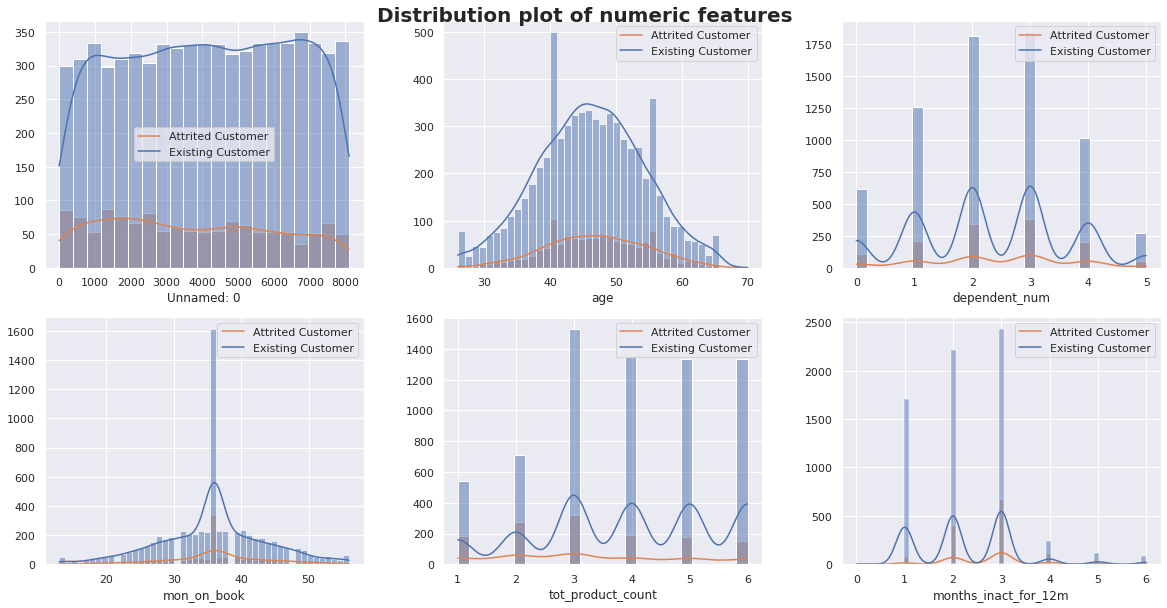

In [12]:
fig,axs=plt.subplots(2,3,figsize=(20,10))
fig.suptitle("Distribution plot of numeric features",y=0.9,fontweight="bold",fontsize=20)
for col,ax in zip(col_num[:7],axs.flatten()):
    b=sns.histplot(x=col,ax=ax,data=df_original,hue="target",kde=True) # lightcoral
    b.legend(labels=["Attrited Customer","Existing Customer"])
    b.set_ylabel("")
    plt.subplots_adjust(wspace=.25)
#fig.delaxes(axs[2,2])

> <font style="color:black; background-color: #dcffe4;">**<U>Think!</U>**</font>
> <font color=orange> (수정필요) 수치형변수 - 분포</font></br>
> 그래프 보고 변수 설명</br>
> mon_on_book</br>
> tot_product_count</br>
> months_inact_for_12m</br>
> contact_cnt_for_12m

* null값<br>
     -> null없음

In [13]:
df[col_num].isnull().sum().sort_values(ascending=False)

contact_cnt_for_12m     0
months_inact_for_12m    0
tot_product_count       0
mon_on_book             0
dependent_num           0
age                     0
Unnamed: 0              0
dtype: int64

* outlier 확인<br>
    - 1사분위수 - 1.5 * IQR 보다 작은 값
    - 3사분위수 + 1.5 * IQR 보다 큰 값

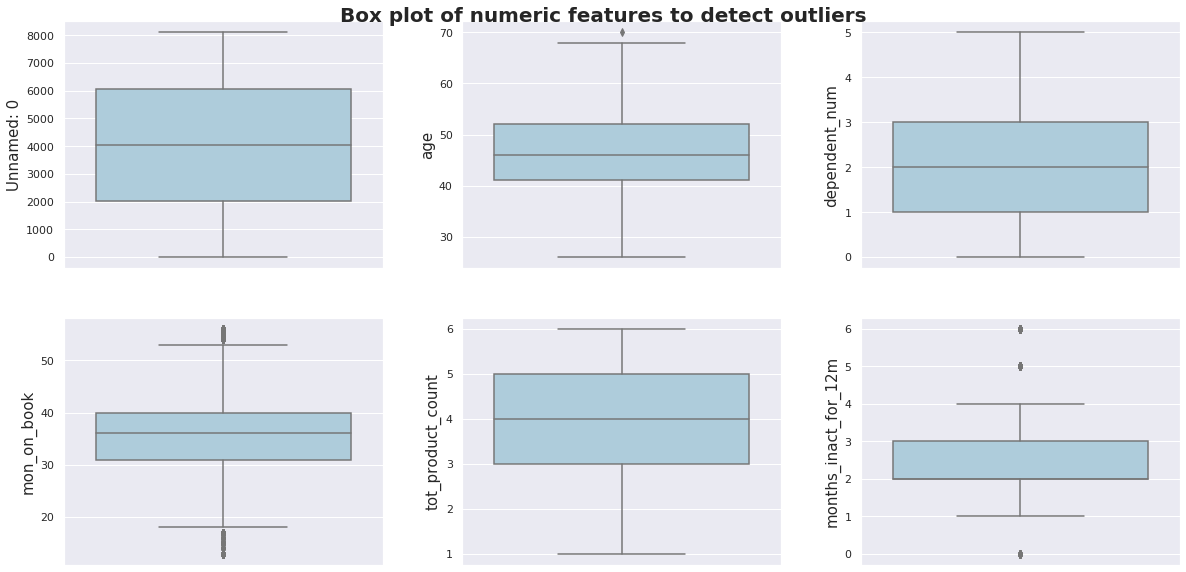

In [14]:
fig,axs=plt.subplots(2,3,figsize=(20,10))
fig.suptitle("Box plot of numeric features to detect outliers",y=0.9,fontweight="bold",fontsize=20)
for col,ax in zip(col_num,axs.flatten()):
    b=sns.boxplot(y=df[col],ax=ax,palette='Paired') #yellowgreen ,color="lightblue"
    b.set_ylabel(col,fontsize=15)
    plt.subplots_adjust(wspace=.25)
#fig.delaxes(axs[1,2])

> <br> <font style="color:black; background-color: #dcffe4; font-size: 18px;">**&nbsp;Think !&nbsp;**</font> <br><br>
**수치형변수 - outlier**  <br>
> &emsp;age <br>
> &emsp;mon_on_book <br>
> &emsp;months_inact_for_12m <br>
> &emsp;contact_cnt_for_12m <br><br>  
> &emsp; → outlier가 존재하는 변수에 대한 처리 필요 <br><br>  
  

----

##### (3) 연속형변수(col_con)
   * basic statistics

In [15]:
df[col_con].describe()

,credit_line,tot_revol_balance,mean_open_to_buy,tot_amt_ratio_q4_q1,tot_trans_amt_for_12m,tot_trans_cnt_for_12m,tot_cnt_ratio_q4_q1,mean_util_pct
count,8101.000000,6580.000000,8101.000000,5666.000000,6432.000000,4851.000000,6472.000000,5575.000000
mean,8636.548068,1158.693313,7476.165276,0.761457,4438.785448,64.568336,0.709951,0.274055
std,9086.419557,814.653118,9080.279910,0.217645,3451.913558,23.659213,0.234484,0.275833
min,1438.300000,0.000000,3.000000,0.000000,510.000000,11.000000,0.000000,0.000000
25%,2555.000000,324.750000,1341.000000,0.631000,2152.750000,44.500000,0.581000,0.023000
50%,4549.000000,1272.000000,3495.000000,0.739000,3905.000000,67.000000,0.700000,0.175000
75%,11128.000000,1777.250000,9942.000000,0.862000,4754.250000,80.000000,0.818000,0.501000
max,34516.000000,2517.000000,34516.000000,2.594000,18484.000000,139.000000,3.571000,0.999000


* 분포

/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional inde

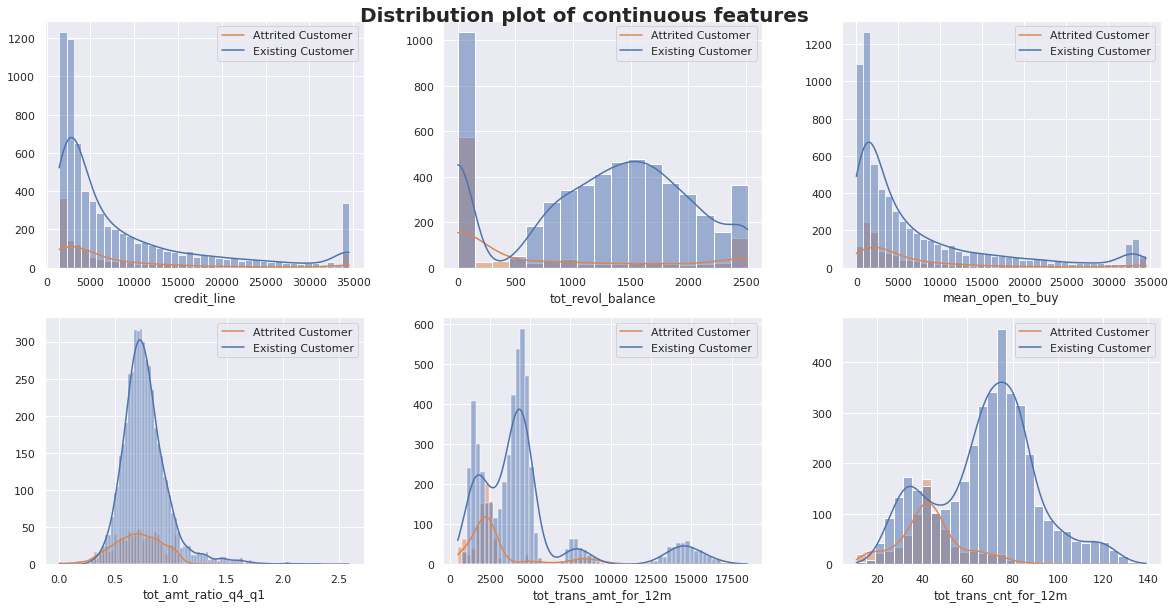

In [16]:
fig,axs=plt.subplots(2,3,figsize=(20,10))
fig.suptitle("Distribution plot of continuous features",y=0.9,fontweight="bold",fontsize=20)
for col,ax in zip(col_con, axs.flatten()):
    b=sns.histplot(x=col,ax=ax, data=df_original,hue="target",kde=True) # lightcoral
    b.legend(labels=["Attrited Customer","Existing Customer"])
    b.set_ylabel("")
    plt.subplots_adjust(wspace=.25)
#fig.delaxes(axs[2,2])

* null

In [17]:
df[col_con].isnull().sum().sort_values(ascending=False)

tot_trans_cnt_for_12m    3250
mean_util_pct            2526
tot_amt_ratio_q4_q1      2435
tot_trans_amt_for_12m    1669
tot_cnt_ratio_q4_q1      1629
tot_revol_balance        1521
mean_open_to_buy            0
credit_line                 0
dtype: int64

> <br> <font style="color:black; background-color: #dcffe4; font-size: 18px;">**&nbsp;Think !&nbsp;**</font> <br><br>
**연속형변수 - null**  <br>
> &emsp;tot_trans_cnt_for_12m     <br>
> &emsp;mean_util_pct             <br>
> &emsp;tot_amt_ratio_q4_q1 <br>
> &emsp;tot_cnt_ratio_q4_q1  <br> 
> &emsp;tot_revol_balance <br><br>  
> &emsp; → null이 존재하는 변수에 대한 처리 필요 <br><br>  
  

* outlier 확인

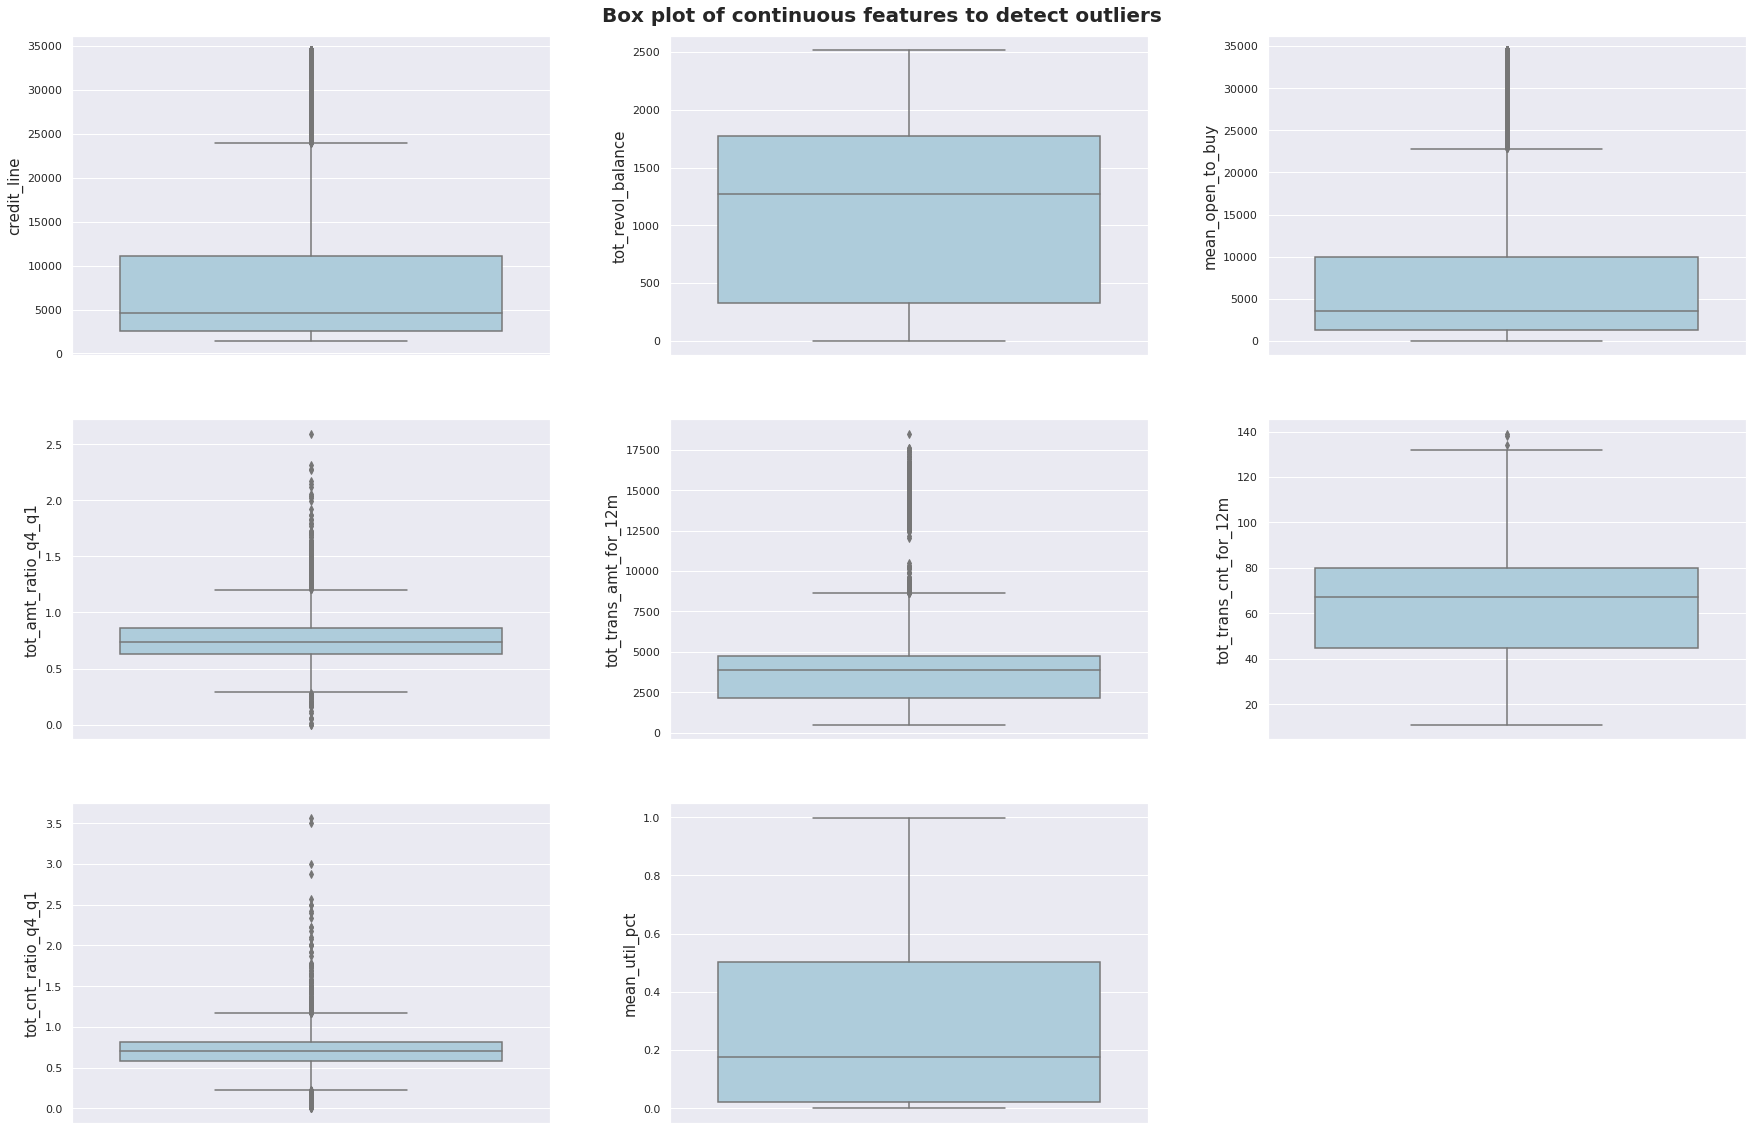

In [18]:
fig,axs=plt.subplots(3,3,figsize=(30,20))
fig.suptitle("Box plot of continuous features to detect outliers",y=0.9,fontweight="bold",fontsize=20)
for col,ax in zip(col_con,axs.flatten()):
    b=sns.boxplot(y=df[col],ax=ax,palette="Paired") #yellowgreen color="Set2"
    b.set_ylabel(col,fontsize=15)
    plt.subplots_adjust(wspace=.25)
fig.delaxes(axs[2,2])

> <br> <font style="color:black; background-color: #dcffe4; font-size: 18px;">**&nbsp;Think !&nbsp;**</font> <br><br>
**연속형변수 - outlier**  <br>
> &emsp; → outlier가 존재하는 변수에 대한 처리 필요 <br><br>  
  

----

##### (4) 범주형변수(col_cat)
   * 범주형 변수 유효값 확인

In [19]:
for col in df.columns:
    if df.loc[:, col].dtype == 'object' :
        print(f'{col:12s}' ,'→ ',f'{df[col].unique()}')

sex          →  ['F' 'M' nan]
education    →  ['High School' 'Unknown' 'Doctorate' 'Uneducated' 'Graduate' 'College'
 'Post-Graduate']
marital_stat →  ['Married' 'Single' 'Divorced' 'Unknown']
imcome_cat   →  ['Less than $40K' '$40K - $60K' '$80K - $120K' 'Unknown' '$60K - $80K' nan
 '$120K +']
card_type    →  ['Blue' 'Silver' 'Gold' 'Platinum']


* 분포

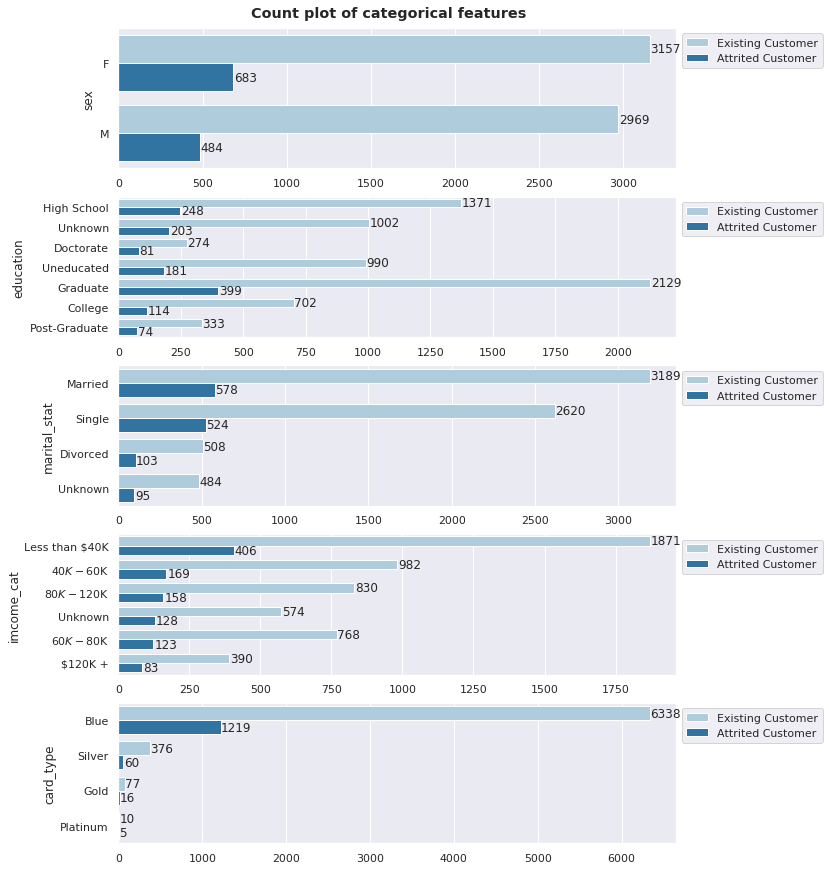

In [20]:
sns.set_theme(style="darkgrid")
fig,axs=plt.subplots(5,1,figsize=(10,15))
i=0
fig.suptitle("Count plot of categorical features",y=0.9,fontweight="bold")
for col in col_cat:
    b=sns.countplot(data=df_original,y=col,ax=axs[i],hue="target",palette="Paired") # "Paired" ,palette="Set2"
    b.set_xlabel(" ")
    b.legend(labels=["Existing Customer","Attrited Customer"],loc = 2, bbox_to_anchor = (1,1))
    for p in b.patches:
        height = p.get_height() 
        width = p.get_width()
        axs[i].text(x = width+3,
                y = p.get_y()+(height/2),
                s = "{:.0f}".format(width),
                va = "center")
    i+=1

* null

In [21]:
df[col_cat].isnull().sum().sort_values(ascending=False)

imcome_cat      1619
sex              808
card_type          0
marital_stat       0
education          0
dtype: int64

> <br> <font style="color:black; background-color: #dcffe4; font-size: 18px;">**&nbsp;Think !&nbsp;**</font> <br><br>
**범주형변수 - null값**  <br>
> &emsp;imcome_cat <br>
> &emsp;sex  <br><br> 
> &emsp; → null값에 대한 처리가 필요 <br><br>  
  

# 3. EDA

### 3-1. dealing with the null
    - null처리 : 수치형(null없음), 연속형, 범주형

In [22]:
# checking for null values --> 8개의 columns에 null존재
pd.DataFrame({'dtype' : df_original.dtypes,
              'count' : df_original.isnull().sum(),
              'prob'  : round(df_original.isnull().sum()/df.shape[0] ,4)}).sort_values('count',ascending = False)

,dtype,count,prob
tot_trans_cnt_for_12m,float64,3250,0.4012
mean_util_pct,float64,2526,0.3118
tot_amt_ratio_q4_q1,float64,2435,0.3006
tot_trans_amt_for_12m,float64,1669,0.2060
tot_cnt_ratio_q4_q1,float64,1629,0.2011
imcome_cat,object,1619,0.1999
tot_revol_balance,float64,1521,0.1878
sex,object,808,0.0997
Unnamed: 0,int64,0,0.0000
credit_line,float64,0,0.0000


결측치 처리방법 → 제거 & 대치<br>
* [대치]<br>
 simpleimputer 사용<br>
    - 평균  / 최빈값 


In [23]:
# 1. 연속형 변수 NULL처리
# my try null처리 방법 : mean, knn, simpleimputer 3가지

In [24]:
# my try null처리 방법 : 1. mean
def process_null_mean(x) :
    for col in x :
        df[f'{col}'].fillna(df[f'{col}'].mean(), inplace=True)
        print(f'{col:25s}  → 평균값으로 대체  → ', df[f'{col}'].isnull().sum())
    return df

In [25]:
# my try null처리 방법 : 2. knn 
def process_null_knn(df):

    for col in df.columns:
        if df.loc[:, f'{col}'].dtype == 'float64' :
            imputer = KNNImputer(n_neighbors=5)
            imputed_df = imputer.fit_transform(df[col_con])
            df[col_con] = pd.DataFrame(imputed_df, columns = df[col_con].columns)
            print(f'{col:25s}  →', "knnImputer처리",  df[f'{col}'].isnull().sum())
    return df

process_null_knn(df)

credit_line                → knnImputer처리 0
tot_revol_balance          → knnImputer처리 0
mean_open_to_buy           → knnImputer처리 0
tot_amt_ratio_q4_q1        → knnImputer처리 0
tot_trans_amt_for_12m      → knnImputer처리 0
tot_trans_cnt_for_12m      → knnImputer처리 0
tot_cnt_ratio_q4_q1        → knnImputer처리 0
mean_util_pct              → knnImputer처리 0


,Unnamed: 0,age,sex,dependent_num,education,marital_stat,imcome_cat,card_type,mon_on_book,tot_product_count,months_inact_for_12m,contact_cnt_for_12m,credit_line,tot_revol_balance,mean_open_to_buy,tot_amt_ratio_q4_q1,tot_trans_amt_for_12m,tot_trans_cnt_for_12m,tot_cnt_ratio_q4_q1,mean_util_pct
0,0,45,F,3,High School,Married,Less than $40K,Blue,36,4,3,3,3544.0,1640.6,1883.0,0.8310,5294.8,111.0,0.7340,0.4690
1,1,58,M,0,Unknown,Single,$40K - $60K,Blue,45,3,1,3,3421.0,2517.0,904.0,0.9920,992.0,21.0,0.4000,0.7374
2,2,46,M,3,Doctorate,Divorced,$80K - $120K,Blue,38,6,3,3,8258.0,1771.0,6487.0,0.6220,1447.0,23.0,0.0000,0.2140
3,3,34,F,2,Uneducated,Single,Less than $40K,Blue,24,6,2,2,1438.3,0.0,1438.3,0.8270,3940.0,82.0,0.9520,0.0000
4,4,49,F,2,Uneducated,Married,Unknown,Blue,41,3,5,2,3128.0,749.0,2379.0,0.5980,1968.0,50.8,0.4064,0.2390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,8096,41,F,3,College,Married,NaN,Blue,37,3,1,2,1438.3,765.0,673.3,0.9438,4053.0,69.0,0.8450,0.5320
8097,8097,50,M,0,Uneducated,Married,$60K - $80K,Blue,46,4,1,3,3640.0,659.0,2981.0,0.6456,8470.4,94.4,0.8420,0.1810
8098,8098,49,F,3,High School,Married,Less than $40K,Blue,45,3,2,3,2951.0,2437.0,514.0,0.7926,3012.8,51.6,0.5650,0.8318
8099,8099,54,M,4,Graduate,Married,$120K +,Blue,50,4,2,0,2872.0,2035.0,837.0,0.6130,1770.0,51.0,0.7410,0.7090


In [26]:
# my try null처리 방법 : 3.simpleimputer
def process_null_simpleimputer(x_train, x_test):
    # 연속형 변수 null처리  → 평균
    con_imputer = SimpleImputer(strategy='mean')      
    con_imputer.fit(x_train[col_con])
    x_train[col_con] = con_imputer.transform(x_train[col_con])
    x_test[col_con] = con_imputer.transform(x_test[col_con])

    # 범주형 변수 null처리  →  최빈값
    cat_imputer = SimpleImputer(strategy='most_frequent')  
    cat_imputer.fit_transform(x_train[col_cat])
    x_train[col_cat] = cat_imputer.fit_transform(x_train[col_cat])
    x_test[col_cat] = cat_imputer.transform(x_test[col_cat])

    print("연속형 → SimpleImputer처리\n",  x_train[col_con].isnull().sum())
    print("범주형 → SimpleImputer처리\n",  x_train[col_cat].isnull().sum())

process_null_simpleimputer(x_train, x_test)

연속형 → SimpleImputer처리
 credit_line              0
tot_revol_balance        0
mean_open_to_buy         0
tot_amt_ratio_q4_q1      0
tot_trans_amt_for_12m    0
tot_trans_cnt_for_12m    0
tot_cnt_ratio_q4_q1      0
mean_util_pct            0
dtype: int64
범주형 → SimpleImputer처리
 sex             0
education       0
marital_stat    0
imcome_cat      0
card_type       0
dtype: int64


/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/python3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

### 3-2. Categorical encoding (범주형변수 치환)
    1) Label Encoding
    2) One-Hot Encoding
    
    → 두가지 방법 중 어떤 방법을 선택?

1) Label Encoding
 - 알파벳 오더순으로 숫자를 할당해주는 것
 - 주로 사용 :
    <ol>
      <li>
        순서가 의미가 있을때(ex.유치원, 초등, 중등, 대학교)
      </li>
      <li>
        고유값의 개수가 많은데 One-hot Encoding은 당연히 메모리 소비가 많으므로 효율적이지 못함
      </li>
    </ol>
 - 적용이 쉽지않음 <br>
    &emsp;why? 알파뱃순으로 숫자정보가 모델 랭크 -> 그로 인해 랭키된 숫자 정보가 모델에 잘못 반영될 수 있음

2) One-Hot Encoding
 - 목록화해서 개별로 그 목록값에 대한 이진값을 만드는 것
 - Dummy 변수를 만든 것을 처리하는 방법
 - 주로 사용 :
    <ol>
      <li>
        순서가 없을때(ex.국가명)
      </li>
      <li>
        고유값의 개수가 많지 않으면 효율적
      </li>
    </ol> <br> 
 - One-Hot Encoding 적용시 문제?  
   Dummy Variable Trap으로 One-Hot Encoding한 변수 하나의 결과가 다른 변수의 도움으로 쉽게 예측되어질 수 있음 <br>
   ->  Dummy variable Trap 변수들이 각각 다른 변수들과 상관성이 있음을 뜻함 ( multicollinearity 문제를 야기 )<br>
   
 - multicollinearity는 독립적인 feature간에 의존성이 있을때 발생하는것으로 선형회귀나 로지스틱 회귀에서 심각한 문제 <br>
   -> 극복방법 : dummy variables중 하나를 제거 <br>
 - One-Hot Encoding 후 multicollinearity를 체크하는 방법중 하나는 Variance Inflation Facotr를 활용

* 카테고리형 컬럼값 종류확인

In [27]:
col_cat

# sex             성별       →   One-Hot 해볼까 했으나 일단 label로!
# education       교육수준   →   Label
# marital_stat    결혼상태   →   One-Hot 해볼까 했으나 일단 label로!
# income_cat      수입규모   →   Label
# card_type       카드종류   →   Label

['sex', 'education', 'marital_stat', 'imcome_cat', 'card_type']

In [28]:
""" 
함수1. 범주형변수의 범주값 치환해주는 함수
       catdgory --> 범주형변수 처리 """
for col in df.columns:
    if df.loc[:, col].dtype == 'object' :
        print(f'{col:12s}' ,'→ ',f'{df[col].unique()}')

sex          →  ['F' 'M' nan]
education    →  ['High School' 'Unknown' 'Doctorate' 'Uneducated' 'Graduate' 'College'
 'Post-Graduate']
marital_stat →  ['Married' 'Single' 'Divorced' 'Unknown']
imcome_cat   →  ['Less than $40K' '$40K - $60K' '$80K - $120K' 'Unknown' '$60K - $80K' nan
 '$120K +']
card_type    →  ['Blue' 'Silver' 'Gold' 'Platinum']


* 카테고리형 데이터를 수치형으로 변환 <br>
  - trian과 test데이터에 같은 값으로 encoding을 하고 싶으면 fit과 transform을 따로 해야함
  - test에도 le.fit(train['col'])했던 값을 transform 해주어야하기 때문

1. Label Encoding

In [29]:
# 1. Labeling 변수list생성
col_cat_label = []
col_cat_label.append(col_cat[1])
#col_cat_label = col_cat_label + col_cat[3:] ;col_cat_label

# 2. Labeling 함수생성
def label_encode(df,x) :
    for col in x :
        # 1.라벨 인코더 생성
        encoder = LabelEncoder()
        # 2. 칼럼에 피팅하고 라벨숫자로 변환
        encoder = encoder.fit(df[f'{col}'])
        df_encoded = encoder.transform(df[f'{col}'])
        df.loc[:,f'{col}_encoded'] = df_encoded
        df.drop(columns = [f'{col}'], inplace=True)
        print(f'{col:15s}', " → ", df_encoded)

label_encode(x_train, col_cat)
label_encode(x_test, col_cat)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

sex              →  [1 1 1 ... 1 0 0]
education        →  [6 2 2 ... 2 2 5]
marital_stat     →  [1 1 2 ... 2 1 2]
imcome_cat       →  [3 3 0 ... 1 4 4]
card_type        →  [0 3 0 ... 0 0 0]
sex              →  [0 0 0 ... 0 1 0]
education        →  [2 1 0 ... 2 5 5]
marital_stat     →  [1 2 2 ... 2 2 0]
imcome_cat       →  [4 4 4 ... 1 4 4]
card_type        →  [0 0 0 ... 0 0 0]


In [30]:
x_test.dtypes

Unnamed: 0                 int64
age                        int64
dependent_num              int64
mon_on_book                int64
tot_product_count          int64
months_inact_for_12m       int64
contact_cnt_for_12m        int64
credit_line              float64
tot_revol_balance        float64
mean_open_to_buy         float64
tot_amt_ratio_q4_q1      float64
tot_trans_amt_for_12m    float64
tot_trans_cnt_for_12m    float64
tot_cnt_ratio_q4_q1      float64
mean_util_pct            float64
sex_encoded                int64
education_encoded          int64
marital_stat_encoded       int64
imcome_cat_encoded         int64
card_type_encoded          int64
dtype: object

### 3-3. dealing with the outliers  → 이상치 확인
    - 이상치처리 : 수치형, 연속형, 범주형

In [31]:
# 숫자형, 연속형  이상치 처리 → 위 그래프 보고 해당 칼럼들 판단
col_numeric_outliers  = df[col_numeric].iloc[:,[0,2,4,5,6,8,9,10,11,12]].columns.tolist()

In [32]:
outlier_list = []

for col in col_numeric_outliers :
  values = x_train.loc[:,col]
  q3, q1 = np.percentile(values, [75,25])
  IQR = q3 - q1
  upper_bound = q3 + 1.5 * IQR
  lower_bound = q1 - 1.5 * IQR
  outliers = np.logical_or(values > upper_bound, values < lower_bound)

  print(f'Upper Bound on {col} : {upper_bound}')
  print(f'Lower Bound on {col} : {lower_bound}')
  print(f'Number of outelier on {col} : {outliers.sum()}')
  print('=========================================================')

  outlier_list.append(outliers)

Upper Bound on Unnamed: 0 : 12173.5
Lower Bound on Unnamed: 0 : -3988.5
Number of outelier on Unnamed: 0 : 0
Upper Bound on dependent_num : 6.0
Lower Bound on dependent_num : -2.0
Number of outelier on dependent_num : 0
Upper Bound on tot_product_count : 8.0
Lower Bound on tot_product_count : 0.0
Number of outelier on tot_product_count : 0
Upper Bound on months_inact_for_12m : 4.5
Lower Bound on months_inact_for_12m : 0.5
Number of outelier on months_inact_for_12m : 179
Upper Bound on contact_cnt_for_12m : 4.5
Lower Bound on contact_cnt_for_12m : 0.5
Number of outelier on contact_cnt_for_12m : 340
Upper Bound on tot_revol_balance : 2970.25
Lower Bound on tot_revol_balance : -555.75
Number of outelier on tot_revol_balance : 0
Upper Bound on mean_open_to_buy : 22536.75
Lower Bound on mean_open_to_buy : -11399.25
Number of outelier on mean_open_to_buy : 539
Upper Bound on tot_amt_ratio_q4_q1 : 0.9758749999999996
Lower Bound on tot_amt_ratio_q4_q1 : 0.5088750000000004
Number of outelier on

In [33]:
# 총 outlier 개수
outliers = list(map(sum, outlier_list))
print(f'Number of Total Outliers : {sum(outliers)}') 

Number of Total Outliers : 3960


* my try : 이상치 처리방법
1. 이상치 값 대체 --> 상한가, 하한가
2. 데이터셋 축소/과장(scaling)  --> 0~1사이의 값으로 변환  
3. 데이터 셋 최소최대척도(MinMax Scaling)
    - 최대값1, 최소값0으로 변환한 뒤 각 구간값을 0~1 사이 스케일로 적용하는 방식
    - MinMax_Scale = {(관측값x)-(최소값Min)}/{(최대값Max)-(최소값Min)}
4. 데이터셋 정규화(Normalize) - Z값(Z-Score)

In [34]:
# 1. 이상치 값 대체 → 상한가, 하한가
#   detecting columns with outliers and replacing data with outliers with np.nan
def outlier_train(col):
    x  = x_train[col].copy()
    q3 = x.quantile(0.75)
    q1 = x.quantile(0.25)
    iqr= q3-q1
    for idx,entry in enumerate(x_train[col]):
        if (entry>q3+1.5*iqr):
            x_train.loc[idx,col]=q3+1.5*iqr
        elif (entry<q1-1.5*iqr):
            x_train.loc[idx,col]=q1-1.5*iqr
        
    return x[(x>q3+1.5*iqr)|(x<q1-1.5*iqr)]

def outlier_test(col):
    x  = x_test[col].copy()
    q3 = x.quantile(0.75)
    q1 = x.quantile(0.25)
    iqr= q3-q1
    for idx,entry in enumerate(x_test[col]):
        if (entry>q3+1.5*iqr):
            x_test.loc[idx,col]=q3+1.5*iqr
        elif (entry<q1-1.5*iqr):
            x_test.loc[idx,col]=q1-1.5*iqr
        
    return x[(x>q3+1.5*iqr)|(x<q1-1.5*iqr)]

for col in col_numeric_outliers:
    pass
    #outlier_train(col)
    #outlier_test(col)

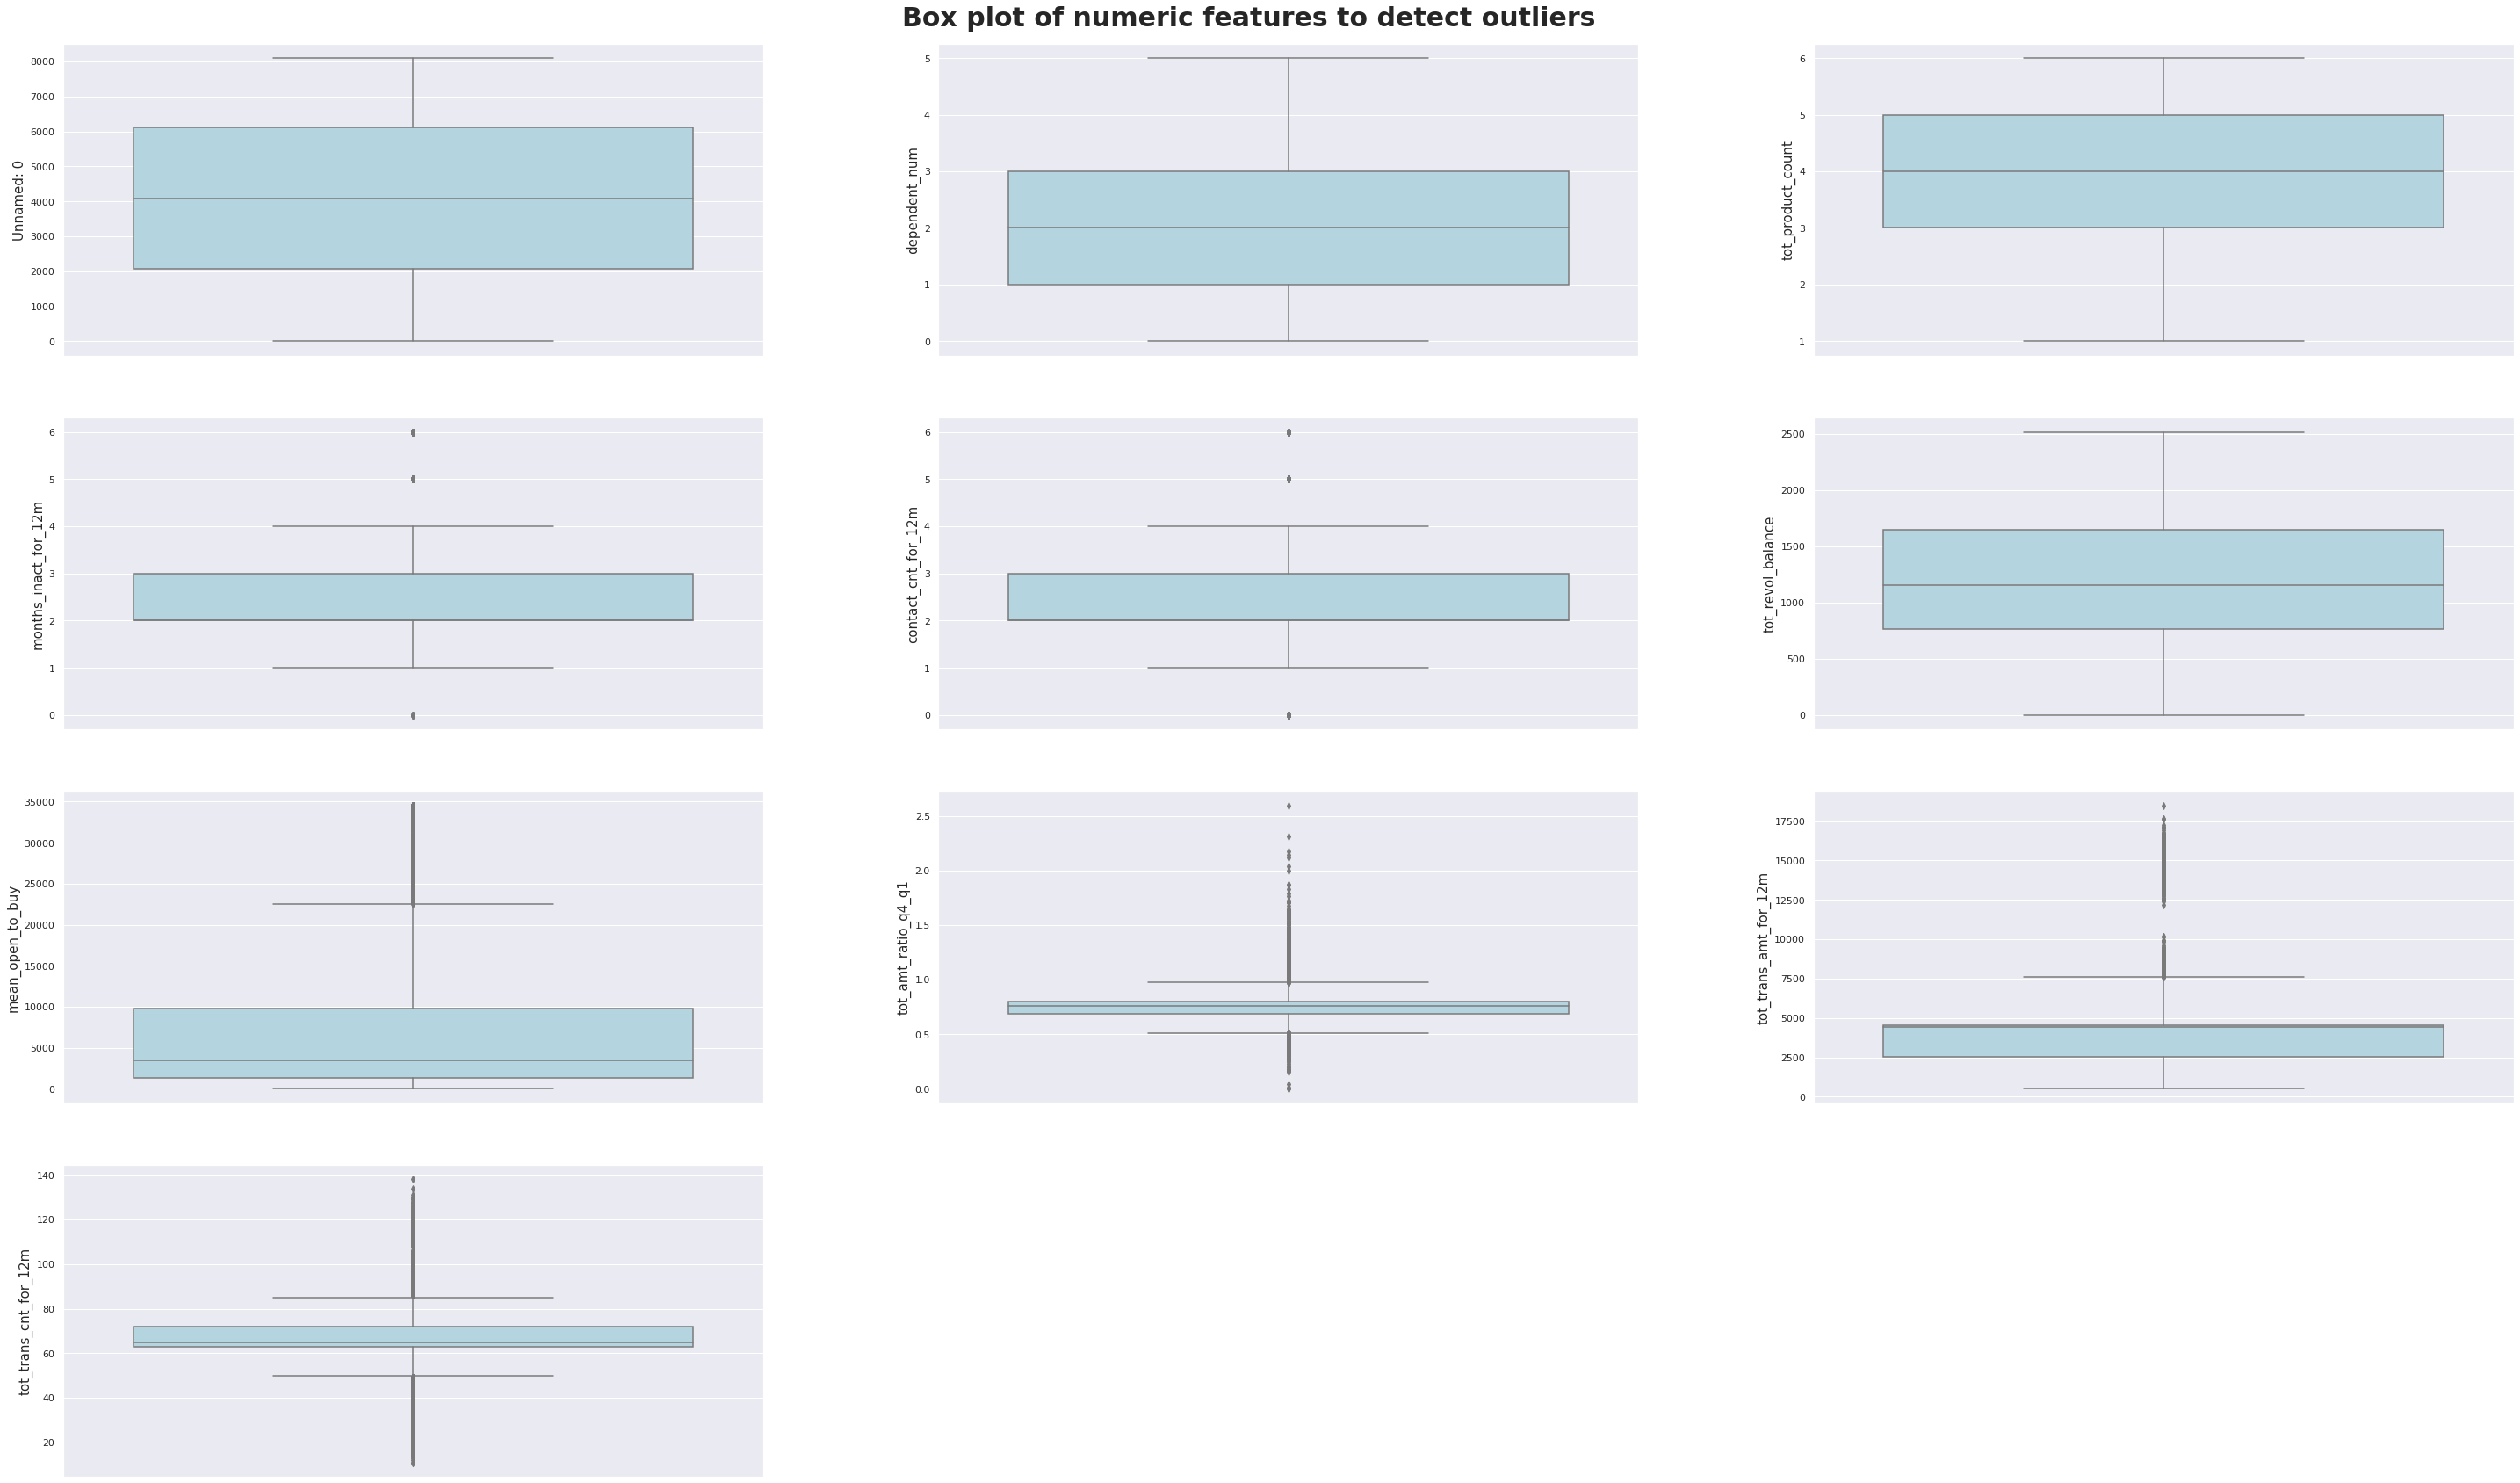

In [35]:
# outlier 확인 
fig,axs=plt.subplots(4,3,figsize=(50,30))
fig.suptitle("Box plot of numeric features to detect outliers",y=0.9,fontweight="bold",fontsize=30)
for col,ax in zip(col_numeric_outliers,axs.flatten()):
    b=sns.boxplot(y= x_train[col],ax=ax,color="lightblue") #yellowgreen
    b.set_ylabel(col,fontsize=15)
    plt.subplots_adjust(wspace=.25)
fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])

### 3-4 Feature Scaling

Dataset의 각 feature (column)간에 scale차이가 크다면 model이 scale이 큰 feature에 sensitive하게 학습 될 수 있습니다. 따라서 적절한 Feature Scaling방법을 통해 Normalize를 해주고 학습하는게 도움이 됩니다.
본 예제에서는 각 Feature를 정규화 시키는 Standard Scaling방법을 이용하겠습니다.


In [36]:
# Feature Scaling

def f_sacling(df): 
    scaler = StandardScaler()
    scaler.fit(x_train)
    Scaled_X = scaler.transform(df)
    
    scaled_df = pd.DataFrame(Scaled_X, columns=df.columns)
    return scaled_df      

f_sacling(x_train)
f_sacling(x_test)                                                                          


,Unnamed: 0,age,dependent_num,mon_on_book,tot_product_count,months_inact_for_12m,contact_cnt_for_12m,credit_line,tot_revol_balance,mean_open_to_buy,tot_amt_ratio_q4_q1,tot_trans_amt_for_12m,tot_trans_cnt_for_12m,tot_cnt_ratio_q4_q1,mean_util_pct,sex_encoded,education_encoded,marital_stat_encoded,imcome_cat_encoded,card_type_encoded
0,-0.542548,0.711056,1.298544,0.012418,1.417591,0.652077,-1.319042,-0.613625,-3.107160e-16,-0.655436,-0.162509,0.000000,0.607568,0.262840,-2.434220e-16,-0.851764,-0.593424,-0.611216,0.645876,-0.257716
1,1.217051,0.586560,-1.037599,0.510898,0.774623,0.652077,-0.406194,-0.788566,-3.107160e-16,-0.761663,-0.817886,0.072276,0.498410,0.870534,1.566297e+00,-0.851764,-1.137084,0.748907,0.645876,-0.257716
2,0.818740,1.582531,-1.037599,1.507857,0.774623,-0.338884,-2.231891,-0.660049,1.005440e+00,-0.741461,0.074783,0.153392,0.000000,0.281538,1.982882e+00,-0.851764,-1.680745,0.748907,0.645876,-0.257716
3,-0.359471,-0.160418,1.298544,0.012418,-1.797249,0.652077,0.506655,-0.429366,-1.574593e+00,-0.301935,-0.942181,0.268471,0.000000,0.159999,-2.434220e-16,-0.851764,0.493897,0.748907,-1.455567,-0.257716
4,1.285651,0.835553,-0.258885,1.133998,0.131655,1.643038,1.419504,1.478991,2.169448e-01,1.462143,-1.789652,-0.996079,-1.520998,0.000000,-2.434220e-16,1.174034,-1.680745,-0.611216,-0.054605,-0.257716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,-1.552688,0.337567,-0.258885,0.635518,0.774623,0.652077,-0.406194,-0.665133,9.056826e-01,-0.738476,0.492868,0.038973,0.552989,0.552663,-2.434220e-16,-0.851764,1.581217,0.748907,0.645876,-0.257716
2427,-0.912132,-0.907396,-1.037599,0.012418,0.774623,0.652077,0.506655,1.816670,-3.775015e-01,1.848042,0.560666,0.000000,0.000000,1.576394,-1.047223e+00,1.174034,1.581217,0.748907,-0.054605,-0.257716
2428,1.405273,0.586560,-0.258885,1.133998,0.774623,-1.329845,0.506655,-0.788566,-3.870673e-01,-0.757351,0.000000,-0.102156,-0.320269,1.197754,1.447900e+00,-0.851764,-0.593424,0.748907,-1.455567,-0.257716
2429,-1.408198,-2.276856,-1.037599,-2.230741,1.417591,0.652077,-0.406194,0.887748,7.703948e-01,0.825907,0.000000,-0.611273,0.000000,-0.288760,-7.490361e-01,1.174034,1.037557,0.748907,0.645876,-0.257716


In [37]:
f_sacling(x_train)
f_sacling(x_test)

,Unnamed: 0,age,dependent_num,mon_on_book,tot_product_count,months_inact_for_12m,contact_cnt_for_12m,credit_line,tot_revol_balance,mean_open_to_buy,tot_amt_ratio_q4_q1,tot_trans_amt_for_12m,tot_trans_cnt_for_12m,tot_cnt_ratio_q4_q1,mean_util_pct,sex_encoded,education_encoded,marital_stat_encoded,imcome_cat_encoded,card_type_encoded
0,-0.542548,0.711056,1.298544,0.012418,1.417591,0.652077,-1.319042,-0.613625,-3.107160e-16,-0.655436,-0.162509,0.000000,0.607568,0.262840,-2.434220e-16,-0.851764,-0.593424,-0.611216,0.645876,-0.257716
1,1.217051,0.586560,-1.037599,0.510898,0.774623,0.652077,-0.406194,-0.788566,-3.107160e-16,-0.761663,-0.817886,0.072276,0.498410,0.870534,1.566297e+00,-0.851764,-1.137084,0.748907,0.645876,-0.257716
2,0.818740,1.582531,-1.037599,1.507857,0.774623,-0.338884,-2.231891,-0.660049,1.005440e+00,-0.741461,0.074783,0.153392,0.000000,0.281538,1.982882e+00,-0.851764,-1.680745,0.748907,0.645876,-0.257716
3,-0.359471,-0.160418,1.298544,0.012418,-1.797249,0.652077,0.506655,-0.429366,-1.574593e+00,-0.301935,-0.942181,0.268471,0.000000,0.159999,-2.434220e-16,-0.851764,0.493897,0.748907,-1.455567,-0.257716
4,1.285651,0.835553,-0.258885,1.133998,0.131655,1.643038,1.419504,1.478991,2.169448e-01,1.462143,-1.789652,-0.996079,-1.520998,0.000000,-2.434220e-16,1.174034,-1.680745,-0.611216,-0.054605,-0.257716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,-1.552688,0.337567,-0.258885,0.635518,0.774623,0.652077,-0.406194,-0.665133,9.056826e-01,-0.738476,0.492868,0.038973,0.552989,0.552663,-2.434220e-16,-0.851764,1.581217,0.748907,0.645876,-0.257716
2427,-0.912132,-0.907396,-1.037599,0.012418,0.774623,0.652077,0.506655,1.816670,-3.775015e-01,1.848042,0.560666,0.000000,0.000000,1.576394,-1.047223e+00,1.174034,1.581217,0.748907,-0.054605,-0.257716
2428,1.405273,0.586560,-0.258885,1.133998,0.774623,-1.329845,0.506655,-0.788566,-3.870673e-01,-0.757351,0.000000,-0.102156,-0.320269,1.197754,1.447900e+00,-0.851764,-0.593424,0.748907,-1.455567,-0.257716
2429,-1.408198,-2.276856,-1.037599,-2.230741,1.417591,0.652077,-0.406194,0.887748,7.703948e-01,0.825907,0.000000,-0.611273,0.000000,-0.288760,-7.490361e-01,1.174034,1.037557,0.748907,0.645876,-0.257716


### 3-5 Check target distribution
    - oversampling

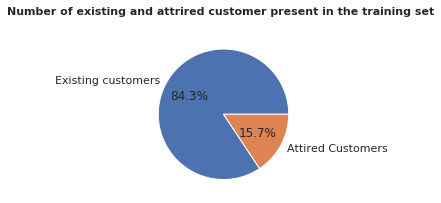

In [38]:
fig,ax=plt.subplots(1,1,figsize=(3, 3))
plt.pie(x=y_train.value_counts(),labels=["Existing customers","Attired Customers"],autopct="%.1f%%")
fig.suptitle("Number of existing and attrired customer present in the training set",y=1,fontweight="bold",fontsize=11)
plt.show()

In [39]:
# data 불균형
_ , num_classes = np.unique(y_train, return_counts=True)
print(f'Class 0 : {num_classes[0]}')
print(f'Class 1 : {num_classes[1]}')

Class 0 : 4782
Class 1 : 888


In [40]:
# oversampling
oversample = SMOTE(sampling_strategy=0.5)
xx, yy = oversample.fit_resample(x_train, y_train)

xx = xx.values
yy = yy.values



In [41]:
x_train.dtypes

Unnamed: 0                 int64
age                        int64
dependent_num              int64
mon_on_book                int64
tot_product_count          int64
months_inact_for_12m       int64
contact_cnt_for_12m        int64
credit_line              float64
tot_revol_balance        float64
mean_open_to_buy         float64
tot_amt_ratio_q4_q1      float64
tot_trans_amt_for_12m    float64
tot_trans_cnt_for_12m    float64
tot_cnt_ratio_q4_q1      float64
mean_util_pct            float64
sex_encoded                int64
education_encoded          int64
marital_stat_encoded       int64
imcome_cat_encoded         int64
card_type_encoded          int64
dtype: object

# 4. Model

## 4-1. Model Selection

In [42]:
rfc=RandomForestClassifier(random_state=0)     # RandomForestClassifier
xgb= XGBClassifier(random_state=0)             # XGBClassifier
ada=AdaBoostClassifier(random_state=0)         # AdaBoostClassifier  
gbc=GradientBoostingClassifier(random_state=0) # GradientBoostingClassifier
lgbm = LGBMClassifier(random_state=0)          # LGBMClassifier

models=[rfc,xgb, ada, gbc, lgbm]

In [43]:
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test, random_state=0, test_size = 0.3)

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
for model in models:
    my_pipeline=Pipeline(steps=[
                                   #("preprocessor",preprocessor),
                                   ("model",model)
                               ])
    my_pipeline.fit(x_train,y_train)
    preds=my_pipeline.predict(x_val)
    y_score=my_pipeline.predict_proba(x_val)[:,1]
    print("Report for ",str(model))
    print('Accuracy Score : {0:.2f}%'.format(accuracy_score(y_val,preds)*100))
    print('Precision Score : {0:.2f}%'.format(precision_score(y_val,preds)*100))
    print('Recall Score : {0:.2f}%'.format(recall_score(y_val,preds)*100))
    print('F1 Score : {0:.2f}%'.format(f1_score(y_val,preds)*100))
    print('Auc Score : {0:.2f}%'.format(roc_auc_score(y_val,y_score)*100))
    

Report for  RandomForestClassifier(random_state=0)
Accuracy Score : 92.77%
Precision Score : 91.71%
Recall Score : 63.95%
F1 Score : 75.35%
Auc Score : 95.90%
[15:36:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Report for  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=64,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
            

LightGBMError: Do not support special JSON characters in feature name.

# Prediction of TEST Data & Result

In [ ]:
from sklearn.inspection import permutation_importance

best_model = models[4]

result = permutation_importance(best_model,x_train,y_train,n_repeats=10,random_state=40,n_jobs=2)

best_model_importances = pd.Series(result.importances_mean, index=x_train.columns.tolist())
fig, ax = plt.subplots(figsize=(10,5))
sns.set(style = "dark")

sns.barplot( x=best_model_importances,y=best_model_importances.index) 
ax.set_title("Feature importances using permutation on full model",fontweight="bold",fontsize=15)
ax.set_ylabel("")
fig.tight_layout()
plt.show()
print("Feature importance scores of each feature sorted in ascending order: ")
best_model_importances.sort_values(ascending=False)

In [ ]:
y_score = best_model.predict_proba(x_test)[:,1]

print("AUC Score : ", roc_auc_score(y_test,y_score))

false_positive_rate, true_positive_rate, threshold =roc_curve(y_test,y_score)

plt.subplots(1, figsize=(10,5))
plt.title('ROC Curve - Best Model')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0,1],ls="--")
plt.plot([0,0],[1,0],c=".7") 
plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 다음 전처리 내용이 있으나 적용되지 않음

In [ ]:
def label_encode(df,x) :
    for col in x :
        # 1.라벨 인코더 생성
        encoder = LabelEncoder()
        # 2. 칼럼에 피팅하고 라벨숫자로 변환
        encoder = encoder.fit(df[f'{col}'])
        df_encoded = encoder.transform(df[f'{col}'])
        df.loc[:,f'{col}_encoded'] = df_encoded
        df.drop(columns = [f'{col}'], inplace=True)
        print(f'{col:15s}', " → ", df_encoded)

col_cat = df.select_dtypes(include=["object"]).columns.tolist()
label_encode(x_test, col_cat)

# Feature Scaling

def f_sacling(df): 
    scaler = StandardScaler()
    scaler.fit(x_train)
    Scaled_X = scaler.transform(df)
    
    scaled_df = pd.DataFrame(Scaled_X, columns=df.columns)
    return scaled_df      

f_sacling(x_train)
f_sacling(x_test)